In [73]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from scipy.stats import linregress
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Reading datasetss
df_stock_train = pd.read_csv("../data/DATA_STOCK_VARS_TRAIN_F.csv")
df_stock_test = pd.read_csv("../data/DATA_STOCK_VARS_TEST_F.csv")

In [16]:
df_stock_train.shape

(73661, 20)

In [21]:
df_stock_test.shape

(26338, 20)

# Juntando data de Transacciones

In [4]:
df_transacciones = pd.read_csv("../data/DATA_TRANSAC_CANALES_F.csv")

In [6]:
df_transacciones.head(1).T

,0
PERIODO,201809.0
ID_CLIENTE,60967.0
CT_RECAUDO,NaN
RGO_MTO_RECAUDO,7.0
CT_TRANSF_INTE,NaN
RGO_MTO_TRANSF_INTE,11.0
CT_CHEQUE_REC,NaN
RGO_MTO_CHEQUE_REC,13.0
CT_TRANSFE_LOCALES,561.0
RGO_MTO_TRANSFE_LOCALES,20.0


In [18]:
#Train
df_stk_trans_train = df_stock_train.merge(df_transacciones, on = 'ID_CLIENTE',how='left')
#Test
df_stk_trans_test = df_stock_test.merge(df_transacciones, on = 'ID_CLIENTE',how='left')


In [19]:
df_stk_trans_train.shape

(120705, 33)

In [20]:
df_stk_trans_test.shape

(42082, 33)

In [22]:
df_stk_trans_train.head(1).T

,0
ID,201808_48117
MES_T0,201808
ID_CLIENTE,48117
FUGA_3M,0
FH_NACIMIENTO,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,8
RGO_SDO_MEDIO_ACTIVO,6
RGO_SDO_MEDIO_PASIVO,9


In [23]:
df_stk_trans_test.head(1).T

,0
ID,201901_62192
MES_T0,201901
ID_CLIENTE,62192
FUGA_3M,NaN
FH_NACIMIENTO,1990-09-24 00:00:00
FH_ALTA,1993-05-12 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,16
RGO_SDO_MEDIO_ACTIVO,18
RGO_SDO_MEDIO_PASIVO,19


## Regla: Usar hast T-1 en entrenamiento.

In [24]:
# Valores validos
df_stk_trans_train_wd = df_stk_trans_train[df_stk_trans_train['MES_T0'] - df_stk_trans_train['PERIODO'] >= 1]
df_stk_trans_test_wd = df_stk_trans_test[df_stk_trans_test['MES_T0'] - df_stk_trans_test['PERIODO'] >= 1]


In [25]:
# Valores no validos
df_stk_trans_train_not_wd = df_stk_trans_train[df_stk_trans_train['MES_T0'] - df_stk_trans_train['PERIODO'] < 1]
df_stk_trans_test_not_wd = df_stk_trans_test[df_stk_trans_test['MES_T0'] - df_stk_trans_test['PERIODO'] < 1]

In [26]:
df_stk_trans_train_wd.shape

(17010, 33)

In [27]:
df_stk_trans_train_not_wd.shape

(40497, 33)

In [47]:
#Analizamos los rangos en el dataset cortado, para evitar corr
corr_cols = ['CT_RECAUDO',  
'RGO_MTO_RECAUDO',           
'CT_TRANSF_INTE',            
'RGO_MTO_TRANSF_INTE',        
'CT_CHEQUE_REC',             
'RGO_MTO_CHEQUE_REC',      
'CT_TRANSFE_LOCALES',       
'RGO_MTO_TRANSFE_LOCALES',  
'CT_PAGO_PROVEE',     
'RGO_MTO_PAGO_PROVEE',
'CT_SUNAT_PYME',
'RGO_MTO_SUNAT_PYME']

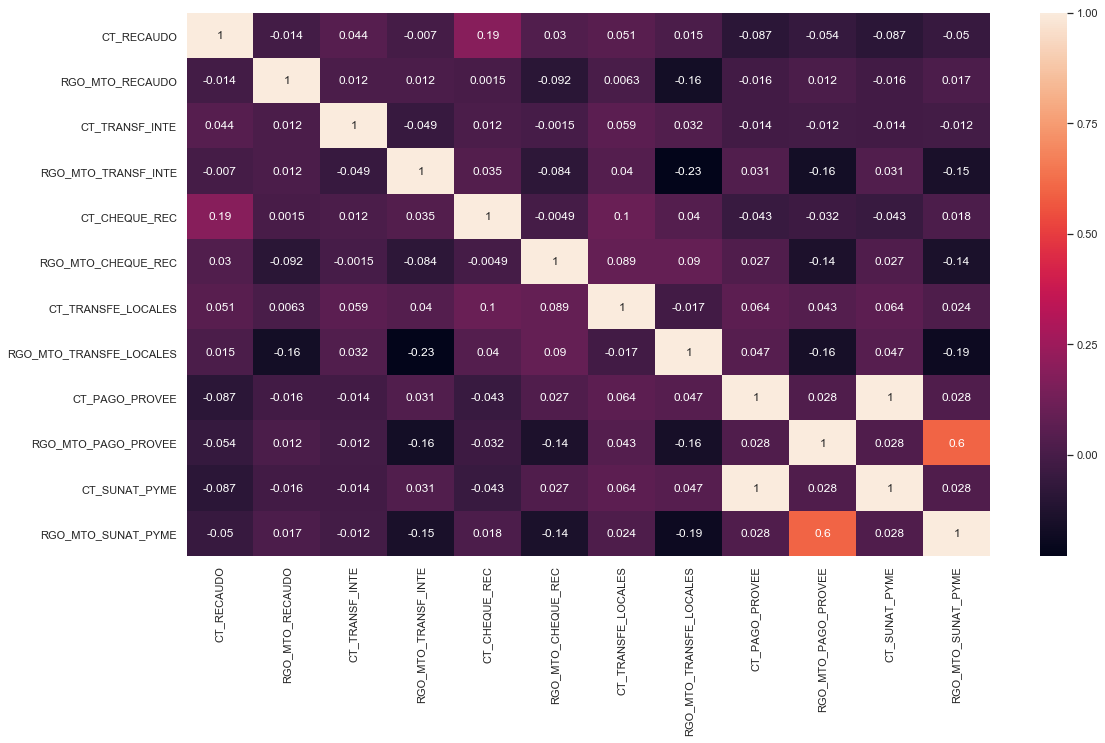

In [50]:
#Train
plt.figure(figsize=(18,10))
sns.heatmap(df_stk_trans_train_wd[corr_cols].corr(),annot=True)

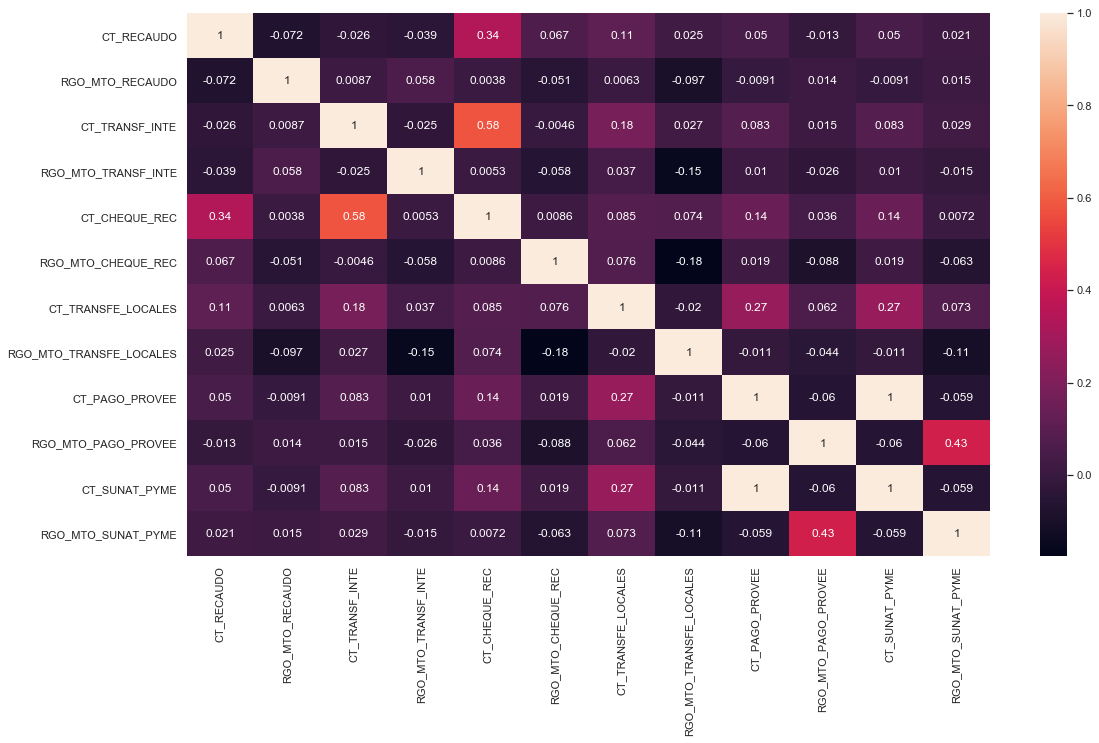

In [51]:
#Test
plt.figure(figsize=(18,10))
sns.heatmap(df_stk_trans_test_wd[corr_cols].corr(),annot=True)

### Analizaremos valores de un cliente, para ver que es lo que ocurre una vez que se pasa la fecha

In [29]:
df_stk_trans_train_wd.merge(df_stk_trans_train_not_wd, on = 'ID_CLIENTE')

,ID_x,MES_T0_x,ID_CLIENTE,FUGA_3M_x,FH_NACIMIENTO_x,FH_ALTA_x,RGO_RIEGO_BBVA_x,RGO_RIESGO_SIST_x,RGO_SDO_MEDIO_ACTIVO_x,RGO_SDO_MEDIO_PASIVO_x,...,CT_TRANSF_INTE_y,RGO_MTO_TRANSF_INTE_y,CT_CHEQUE_REC_y,RGO_MTO_CHEQUE_REC_y,CT_TRANSFE_LOCALES_y,RGO_MTO_TRANSFE_LOCALES_y,CT_PAGO_PROVEE_y,RGO_MTO_PAGO_PROVEE_y,CT_SUNAT_PYME_y,RGO_MTO_SUNAT_PYME_y
0,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,NaN,14.0,459.0,20.0,459.0,10.0,NaN,4.0,NaN,5.0
1,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,NaN,3.0,2295.0,16.0,1836.0,14.0,NaN,8.0,NaN,8.0
2,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,NaN,15.0,1377.0,16.0,1377.0,16.0,NaN,15.0,NaN,10.0
3,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,1.0,20.0,4590.0,19.0,1377.0,12.0,NaN,11.0,NaN,3.0
4,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,2.0,20.0,1377.0,17.0,459.0,8.0,NaN,1.0,NaN,14.0
5,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,NaN,14.0,459.0,20.0,459.0,10.0,NaN,4.0,NaN,5.0
6,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,NaN,3.0,2295.0,16.0,1836.0,14.0,NaN,8.0,NaN,8.0
7,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,NaN,15.0,1377.0,16.0,1377.0,16.0,NaN,15.0,NaN,10.0
8,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,1.0,20.0,4590.0,19.0,1377.0,12.0,NaN,11.0,NaN,3.0
9,201808_48117,201808,48117,0,2015-12-04 00:00:00,2017-09-04 00:00:00,1,8,6,9,...,2.0,20.0,1377.0,17.0,459.0,8.0,NaN,1.0,NaN,14.0


In [32]:
#### Ejemplo: cliente 48117
df_stk_trans_train_wd[df_stk_trans_train_wd['ID_CLIENTE'] == 48117].sort_values(by='PERIODO').T

,6,4
ID,201808_48117,201808_48117
MES_T0,201808,201808
ID_CLIENTE,48117,48117
FUGA_3M,0,0
FH_NACIMIENTO,2015-12-04 00:00:00,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1,1
RGO_RIESGO_SIST,8,8
RGO_SDO_MEDIO_ACTIVO,6,6
RGO_SDO_MEDIO_PASIVO,9,9


In [33]:
#### Ejemplo: cliente 48117
df_stk_trans_train_not_wd[df_stk_trans_train_not_wd['ID_CLIENTE'] == 48117].sort_values(by='PERIODO').T

,3,1,2,0,5
ID,201808_48117,201808_48117,201808_48117,201808_48117,201808_48117
MES_T0,201808,201808,201808,201808,201808
ID_CLIENTE,48117,48117,48117,48117,48117
FUGA_3M,0,0,0,0,0
FH_NACIMIENTO,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00,2017-09-04 00:00:00,2017-09-04 00:00:00,2017-09-04 00:00:00,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1,1,1,1,1
RGO_RIESGO_SIST,8,8,8,8,8
RGO_SDO_MEDIO_ACTIVO,6,6,6,6,6
RGO_SDO_MEDIO_PASIVO,9,9,9,9,9


In [57]:
#### Otro Ejemplo: cliente 25412
df_stk_trans_train_wd[df_stk_trans_train_wd['ID_CLIENTE'] == 25412].sort_values(by='PERIODO').T

,29
ID,201805_25412
MES_T0,201805
ID_CLIENTE,25412
FUGA_3M,0
FH_NACIMIENTO,2001-07-25 00:00:00
FH_ALTA,2001-07-27 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,16
RGO_SDO_MEDIO_ACTIVO,13
RGO_SDO_MEDIO_PASIVO,19


In [58]:
#### Otro Ejemplo: cliente 25412
df_stk_trans_train_not_wd[df_stk_trans_train_not_wd['ID_CLIENTE'] == 25412].sort_values(by='PERIODO').T

,28,32,33,31,30,27
ID,201805_25412,201805_25412,201805_25412,201805_25412,201805_25412,201805_25412
MES_T0,201805,201805,201805,201805,201805,201805
ID_CLIENTE,25412,25412,25412,25412,25412,25412
FUGA_3M,0,0,0,0,0,0
FH_NACIMIENTO,2001-07-25 00:00:00,2001-07-25 00:00:00,2001-07-25 00:00:00,2001-07-25 00:00:00,2001-07-25 00:00:00,2001-07-25 00:00:00
FH_ALTA,2001-07-27 00:00:00,2001-07-27 00:00:00,2001-07-27 00:00:00,2001-07-27 00:00:00,2001-07-27 00:00:00,2001-07-27 00:00:00
RGO_RIEGO_BBVA,1,1,1,1,1,1
RGO_RIESGO_SIST,16,16,16,16,16,16
RGO_SDO_MEDIO_ACTIVO,13,13,13,13,13,13
RGO_SDO_MEDIO_PASIVO,19,19,19,19,19,19


### Analisis por target en 1 y target en 0

In [55]:
df_stk_trans_train_wd[df_stk_trans_train_wd['FUGA_3M'] == 1].merge(df_stk_trans_train_not_wd, on = 'ID_CLIENTE')

,ID_x,MES_T0_x,ID_CLIENTE,FUGA_3M_x,FH_NACIMIENTO_x,FH_ALTA_x,RGO_RIEGO_BBVA_x,RGO_RIESGO_SIST_x,RGO_SDO_MEDIO_ACTIVO_x,RGO_SDO_MEDIO_PASIVO_x,...,CT_TRANSF_INTE_y,RGO_MTO_TRANSF_INTE_y,CT_CHEQUE_REC_y,RGO_MTO_CHEQUE_REC_y,CT_TRANSFE_LOCALES_y,RGO_MTO_TRANSFE_LOCALES_y,CT_PAGO_PROVEE_y,RGO_MTO_PAGO_PROVEE_y,CT_SUNAT_PYME_y,RGO_MTO_SUNAT_PYME_y
0,201810_2878,201810,2878,1,2016-05-20 00:00:00,2016-05-24 00:00:00,2,3,11,4,...,NaN,14.0,NaN,8.0,2448.0,18.0,NaN,10.0,NaN,4.0
1,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,5.0,510.0,16.0,NaN,1.0,NaN,2.0,NaN,3.0
2,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,15.0,NaN,8.0,NaN,2.0,NaN,6.0,NaN,5.0
3,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,1.0,510.0,19.0,NaN,6.0,NaN,2.0,NaN,6.0
4,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,5.0,510.0,16.0,NaN,1.0,NaN,2.0,NaN,3.0
5,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,15.0,NaN,8.0,NaN,2.0,NaN,6.0,NaN,5.0
6,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,1.0,510.0,19.0,NaN,6.0,NaN,2.0,NaN,6.0
7,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,5.0,510.0,16.0,NaN,1.0,NaN,2.0,NaN,3.0
8,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,15.0,NaN,8.0,NaN,2.0,NaN,6.0,NaN,5.0
9,201807_10499,201807,10499,1,2016-12-14 00:00:00,2016-12-29 00:00:00,2,1,17,2,...,NaN,1.0,510.0,19.0,NaN,6.0,NaN,2.0,NaN,6.0


In [56]:
#### Ejemplo: cliente 10499
df_stk_trans_train_wd[df_stk_trans_train_wd['ID_CLIENTE'] == 10499].sort_values(by='PERIODO').T

,5541,5544,5536,5548,5546,5537,5545,5547,5549,5543,5542
ID,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499,201807_10499
MES_T0,201807,201807,201807,201807,201807,201807,201807,201807,201807,201807,201807
ID_CLIENTE,10499,10499,10499,10499,10499,10499,10499,10499,10499,10499,10499
FUGA_3M,1,1,1,1,1,1,1,1,1,1,1
FH_NACIMIENTO,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00,2016-12-14 00:00:00
FH_ALTA,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00,2016-12-29 00:00:00
RGO_RIEGO_BBVA,2,2,2,2,2,2,2,2,2,2,2
RGO_RIESGO_SIST,1,1,1,1,1,1,1,1,1,1,1
RGO_SDO_MEDIO_ACTIVO,17,17,17,17,17,17,17,17,17,17,17
RGO_SDO_MEDIO_PASIVO,2,2,2,2,2,2,2,2,2,2,2


In [37]:
# Usando sòlo data hasta N-1, computamos las variables.
# Vamos a descartar contadores ya que están llenos de nulls.
df_stk_trans_train_wd_agg = df_stk_trans_train_wd.groupby('ID').agg({
                                    'RGO_MTO_RECAUDO':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_TRANSF_INTE':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_CHEQUE_REC':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_TRANSFE_LOCALES':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_PAGO_PROVEE':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_SUNAT_PYME':['sum','min','max','mean','count','std'],
                                    }).reset_index()

df_stk_trans_test_wd_agg = df_stk_trans_test_wd.groupby('ID').agg({
                                    'RGO_MTO_RECAUDO':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_TRANSF_INTE':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_CHEQUE_REC':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_TRANSFE_LOCALES':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_PAGO_PROVEE':['sum','min','max','mean','count','std'],
                                    'RGO_MTO_SUNAT_PYME':['sum','min','max','mean','count','std'],
                                    }).reset_index()

In [46]:
df_stk_trans_test_wd_agg.head(1).T

0
ID                             201812_18396
RGO_MTO_RECAUDO         sum             164
                        min               1
                        max              18
                        mean          10.25
                        count            16
                        std          5.2978
RGO_MTO_TRANSF_INTE     sum             151
                        min               1
                        max              18
                        mean         9.4375
                        count            16
                        std         5.44021
RGO_MTO_CHEQUE_REC      sum             121
                        min               1
                        max              13
                        mean         7.5625
                        count            16
                        std         4.53091
RGO_MTO_TRANSFE_LOCALES sum             113
                        min               1
                        max              20
                        mean         7.0625
                        count            16
                        std         5.76737
RGO_MTO_PAGO_PROVEE     sum             299
                        min              18
                        max              20
                        mean        18.6875
                        count            16
                        std        0.873212
RGO_MTO_SUNAT_PYME      sum             299
                        min              18
                        max              20
                        mean        18.6875
                        count            16
                        std        0.873212

In [52]:
df_stk_trans_train_wd_agg.columns = ['ID',
                                     'RGO_MTO_RECAUDO_sum','RGO_MTO_RECAUDO_min','RGO_MTO_RECAUDO_max','RGO_MTO_RECAUDO_mean','RGO_MTO_RECAUDO_count','RGO_MTO_RECAUDO_std', 
                                     'RGO_MTO_TRANSF_INTE_sum','RGO_MTO_TRANSF_INTE_min','RGO_MTO_TRANSF_INTE_max','RGO_MTO_TRANSF_INTE_mean','RGO_MTO_TRANSF_INTE_count','RGO_MTO_TRANSF_INTE_std',
                                     'RGO_MTO_CHEQUE_REC_sum','RGO_MTO_CHEQUE_REC_min','RGO_MTO_CHEQUE_REC_max','RGO_MTO_CHEQUE_REC_mean','RGO_MTO_CHEQUE_REC_count','RGO_MTO_CHEQUE_REC_std',
                                     'RGO_MTO_TRANSFE_LOCALES_sum','RGO_MTO_TRANSFE_LOCALES_min','RGO_MTO_TRANSFE_LOCALES_max','RGO_MTO_TRANSFE_LOCALES_mean','RGO_MTO_TRANSFE_LOCALES_count','RGO_MTO_TRANSFE_LOCALES_std',
                                     'RGO_MTO_PAGO_PROVEE_sum','RGO_MTO_PAGO_PROVEE_min','RGO_MTO_PAGO_PROVEE_max','RGO_MTO_PAGO_PROVEE_mean','RGO_MTO_PAGO_PROVEE_count','RGO_MTO_PAGO_PROVEE_std',
                                     'RGO_MTO_SUNAT_PYME_sum','RGO_MTO_SUNAT_PYME_min','RGO_MTO_SUNAT_PYME_max','RGO_MTO_SUNAT_PYME_mean','RGO_MTO_SUNAT_PYME_count','RGO_MTO_SUNAT_PYME_std'
                                     ]

df_stk_trans_test_wd_agg.columns = ['ID',
                                     'RGO_MTO_RECAUDO_sum','RGO_MTO_RECAUDO_min','RGO_MTO_RECAUDO_max','RGO_MTO_RECAUDO_mean','RGO_MTO_RECAUDO_count','RGO_MTO_RECAUDO_std', 
                                     'RGO_MTO_TRANSF_INTE_sum','RGO_MTO_TRANSF_INTE_min','RGO_MTO_TRANSF_INTE_max','RGO_MTO_TRANSF_INTE_mean','RGO_MTO_TRANSF_INTE_count','RGO_MTO_TRANSF_INTE_std',
                                     'RGO_MTO_CHEQUE_REC_sum','RGO_MTO_CHEQUE_REC_min','RGO_MTO_CHEQUE_REC_max','RGO_MTO_CHEQUE_REC_mean','RGO_MTO_CHEQUE_REC_count','RGO_MTO_CHEQUE_REC_std',
                                     'RGO_MTO_TRANSFE_LOCALES_sum','RGO_MTO_TRANSFE_LOCALES_min','RGO_MTO_TRANSFE_LOCALES_max','RGO_MTO_TRANSFE_LOCALES_mean','RGO_MTO_TRANSFE_LOCALES_count','RGO_MTO_TRANSFE_LOCALES_std',
                                     'RGO_MTO_PAGO_PROVEE_sum','RGO_MTO_PAGO_PROVEE_min','RGO_MTO_PAGO_PROVEE_max','RGO_MTO_PAGO_PROVEE_mean','RGO_MTO_PAGO_PROVEE_count','RGO_MTO_PAGO_PROVEE_std',
                                     'RGO_MTO_SUNAT_PYME_sum','RGO_MTO_SUNAT_PYME_min','RGO_MTO_SUNAT_PYME_max','RGO_MTO_SUNAT_PYME_mean','RGO_MTO_SUNAT_PYME_count','RGO_MTO_SUNAT_PYME_std'
                                     ]



In [54]:
df_stk_trans_train_wd_agg.to_csv('../data/PROCESS_stk_trans_train_wd_agg.csv',index=False)
df_stk_trans_test_wd_agg.to_csv('../data/PROCESS_stk_trans_test_wd_agg.csv',index=False)

# Juntando data de Endeudamiento

In [59]:
# Reading dataset
df_endeudamiento = pd.read_csv("../data/DATA_ENDEUDAMIENTO_F.csv")

In [60]:
df_endeudamiento.head().T

,0,1,2,3,4
MES,201809.0,201804.0,201805.0,201803.0,201901.0
ID_CLIENTE,97597.0,76119.0,50080.0,98183.0,17109.0
CD_BANCO,231.0,106.0,228.0,107.0,2.0
ST_CREDITO,1.0,1.0,1.0,1.0,1.0
RGO_SDGRANDES_EMP,19.0,19.0,19.0,19.0,19.0
RGO_SDMEDIANAS_EMP,15.0,15.0,15.0,15.0,15.0
RGO_SDPEQUENIAS_EMP,19.0,19.0,19.0,19.0,19.0
RGO_SDMICROEMPRESA,6.0,6.0,6.0,6.0,6.0
RGO_SDDIRECTO,17.0,17.0,17.0,17.0,17.0
RGO_SDINDIRECTO,11.0,11.0,11.0,11.0,11.0


#### Correlaciones:
- RGO_SDAVALES y RGO_SDLEA_PEM
- RGO_SD_SINLEASING, RGO_SDDIRECTO, RGO_SDTOTAL

In [61]:
#Bye
df_endeudamiento_dropped = df_endeudamiento.drop(['RGO_SDLEA_PEM', 'RGO_SD_SINLEASING', 'RGO_SDDIRECTO'], axis=1)

In [62]:
#Train
df_stk_endeu_train = df_stock_train.merge(df_endeudamiento_dropped, on = 'ID_CLIENTE')
#Test
df_stk_endeu_test = df_stock_test.merge(df_endeudamiento_dropped, on = 'ID_CLIENTE')

In [64]:
df_stk_endeu_train.shape

(2284251, 42)

In [65]:
df_stk_endeu_test.shape

(786914, 42)

## Regla: Usar hast T-1 en entrenamiento.

In [69]:
# Valores validos
df_stk_endeu_train_wd = df_stk_endeu_train[df_stk_endeu_train['MES_T0'] - df_stk_endeu_train['MES'] >= 1]
df_stk_endeu_test_wd = df_stk_endeu_test[df_stk_endeu_test['MES_T0'] - df_stk_endeu_test['MES'] >= 1]

In [70]:
df_stk_endeu_train_wd.shape

(1431690, 42)

In [71]:
df_stk_endeu_test_wd.shape

(743256, 42)

In [72]:
df_stk_endeu_train_wd.head(1).T

,0
ID,201808_48117
MES_T0,201808
ID_CLIENTE,48117
FUGA_3M,0
FH_NACIMIENTO,2015-12-04 00:00:00
FH_ALTA,2017-09-04 00:00:00
RGO_RIEGO_BBVA,1
RGO_RIESGO_SIST,8
RGO_SDO_MEDIO_ACTIVO,6
RGO_SDO_MEDIO_PASIVO,9


In [74]:
df_stk_endeu_train_wd.columns

Index(['ID', 'MES_T0', 'ID_CLIENTE', 'FUGA_3M', 'FH_NACIMIENTO', 'FH_ALTA',
       'RGO_RIEGO_BBVA', 'RGO_RIESGO_SIST', 'RGO_SDO_MEDIO_ACTIVO',
       'RGO_SDO_MEDIO_PASIVO', 'RGO_MARGEN_OPER_MES', 'RGO_MARGEN_OPER_ACUM',
       'RGO_FACTURA_ANUAL', 'TO_EMPLEADOS', 'CD_SBS_NORMAL', 'CD_SBS_CPP',
       'CD_SBS_DDP', 'TP_VIVI', 'TP_PERSONA', 'TIPO_NEGOCIO', 'MES',
       'CD_BANCO', 'ST_CREDITO', 'RGO_SDGRANDES_EMP', 'RGO_SDMEDIANAS_EMP',
       'RGO_SDPEQUENIAS_EMP', 'RGO_SDMICROEMPRESA', 'RGO_SDINDIRECTO',
       'RGO_SDTOTAL', 'RGO_SDDESCLETRAS', 'RGO_SDTARJETA_EMP', 'RGO_SDLEASING',
       'RGO_SDCOMEX', 'RGO_SDPREST_EMP', 'RGO_SDFACTORING', 'RGO_SDAVALES',
       'RGO_SDCARTFIANZA', 'RGO_SDCREDITO', 'RGO_SDACEPBANCA',
       'RGO_SDGTIA_HIPOTEC', 'RGO_SDGTIA_PREFE', 'RGO_SD_NOPREFE'],
      dtype='object')

In [76]:
# Usando sòlo data hasta N-1, computamos las variables.
# Vamos a descartar contadores ya que están llenos de nulls.
df_stk_endeu_train_wd_agg = df_stk_endeu_train_wd.groupby('ID').agg({
                                    'CD_BANCO':['nunique'],
                                    'ST_CREDITO':['nunique'],
                                    'RGO_SDGRANDES_EMP':['sum','min','max','mean','count','std'], 
                                    'RGO_SDMEDIANAS_EMP':['sum','min','max','mean','count','std'],
                                    'RGO_SDPEQUENIAS_EMP':['sum','min','max','mean','count','std'],
                                    'RGO_SDMICROEMPRESA':['sum','min','max','mean','count','std'], 
                                    'RGO_SDINDIRECTO':['sum','min','max','mean','count','std'],
                                    'RGO_SDTOTAL':['sum','min','max','mean','count','std'], 
                                    'RGO_SDDESCLETRAS':['sum','min','max','mean','count','std'], 
                                    'RGO_SDTARJETA_EMP':['sum','min','max','mean','count','std'], 
                                    'RGO_SDLEASING':['sum','min','max','mean','count','std'],
                                    'RGO_SDCOMEX':['sum','min','max','mean','count','std'], 
                                    'RGO_SDPREST_EMP':['sum','min','max','mean','count','std'], 
                                    'RGO_SDFACTORING':['sum','min','max','mean','count','std'], 
                                    'RGO_SDAVALES':['sum','min','max','mean','count','std'],
                                    'RGO_SDCARTFIANZA':['sum','min','max','mean','count','std'], 
                                    'RGO_SDCREDITO':['sum','min','max','mean','count','std'], 
                                    'RGO_SDACEPBANCA':['sum','min','max','mean','count','std'],
                                    'RGO_SDGTIA_HIPOTEC':['sum','min','max','mean','count','std'], 
                                    'RGO_SDGTIA_PREFE':['sum','min','max','mean','count','std'], 
                                    'RGO_SD_NOPREFE':['sum','min','max','mean','count','std']
                                    }).reset_index()

df_stk_endeu_test_wd_agg = df_stk_endeu_test_wd.groupby('ID').agg({
                                    'CD_BANCO':['nunique'],
                                    'ST_CREDITO':['nunique'],
                                    'RGO_SDGRANDES_EMP':['sum','min','max','mean','count','std'], 
                                    'RGO_SDMEDIANAS_EMP':['sum','min','max','mean','count','std'],
                                    'RGO_SDPEQUENIAS_EMP':['sum','min','max','mean','count','std'],
                                    'RGO_SDMICROEMPRESA':['sum','min','max','mean','count','std'], 
                                    'RGO_SDINDIRECTO':['sum','min','max','mean','count','std'],
                                    'RGO_SDTOTAL':['sum','min','max','mean','count','std'], 
                                    'RGO_SDDESCLETRAS':['sum','min','max','mean','count','std'], 
                                    'RGO_SDTARJETA_EMP':['sum','min','max','mean','count','std'], 
                                    'RGO_SDLEASING':['sum','min','max','mean','count','std'],
                                    'RGO_SDCOMEX':['sum','min','max','mean','count','std'], 
                                    'RGO_SDPREST_EMP':['sum','min','max','mean','count','std'], 
                                    'RGO_SDFACTORING':['sum','min','max','mean','count','std'], 
                                    'RGO_SDAVALES':['sum','min','max','mean','count','std'],
                                    'RGO_SDCARTFIANZA':['sum','min','max','mean','count','std'], 
                                    'RGO_SDCREDITO':['sum','min','max','mean','count','std'], 
                                    'RGO_SDACEPBANCA':['sum','min','max','mean','count','std'],
                                    'RGO_SDGTIA_HIPOTEC':['sum','min','max','mean','count','std'], 
                                    'RGO_SDGTIA_PREFE':['sum','min','max','mean','count','std'], 
                                    'RGO_SD_NOPREFE':['sum','min','max','mean','count','std']
                                    }).reset_index()

In [78]:
df_stk_endeu_train_wd_agg.columns = ['ID','CD_BANCO_nunique','ST_CREDITO_nunique',
                                     'RGO_SDGRANDES_EMP_sum','RGO_SDGRANDES_EMP_min','RGO_SDGRANDES_EMP_max','RGO_SDGRANDES_EMP_mean','RGO_SDGRANDES_EMP_count','RGO_SDGRANDES_EMP_std', 
                                     'RGO_SDMEDIANAS_EMP_sum','RGO_SDMEDIANAS_EMP_min','RGO_SDMEDIANAS_EMP_max','RGO_SDMEDIANAS_EMP_mean','RGO_SDMEDIANAS_EMP_count','RGO_SDMEDIANAS_EMP_std',
                                     'RGO_SDPEQUENIAS_EMP_sum','RGO_SDPEQUENIAS_EMP_min','RGO_SDPEQUENIAS_EMP_max','RGO_SDPEQUENIAS_EMP_mean','RGO_SDPEQUENIAS_EMP_count','RGO_SDPEQUENIAS_EMP_std',
                                     'RGO_SDMICROEMPRESA_sum','RGO_SDMICROEMPRESA_min','RGO_SDMICROEMPRESA_max','RGO_SDMICROEMPRESA_mean','RGO_SDMICROEMPRESA_count','RGO_SDMICROEMPRESA_std',
                                     'RGO_SDINDIRECTO_sum','RGO_SDINDIRECTO_min','RGO_SDINDIRECTO_max','RGO_SDINDIRECTO_mean','RGO_SDINDIRECTO_count','RGO_SDINDIRECTO_std',
                                     'RGO_SDTOTAL_sum','RGO_SDTOTAL_min','RGO_SDTOTAL_max','RGO_SDTOTAL_mean','RGO_SDTOTAL_count','RGO_SDTOTAL_std',
                                     'RGO_SDDESCLETRAS_sum','RGO_SDDESCLETRAS_min','RGO_SDDESCLETRAS_max','RGO_SDDESCLETRAS_mean','RGO_SDDESCLETRAS_count','RGO_SDDESCLETRAS_std',
                                     'RGO_SDTARJETA_EMP_sum','RGO_SDTARJETA_EMP_min','RGO_SDTARJETA_EMP_max','RGO_SDTARJETA_EMP_mean','RGO_SDTARJETA_EMP_count','RGO_SDTARJETA_EMP_std',
                                     'RGO_SDLEASING_sum','RGO_SDLEASING_min','RGO_SDLEASING_max','RGO_SDLEASING_mean','RGO_SDLEASING_count','RGO_SDLEASING_std',
                                     'RGO_SDCOMEX_sum','RGO_SDCOMEX_min','RGO_SDCOMEX_max','RGO_SDCOMEX_mean','RGO_SDCOMEX_count','RGO_SDCOMEX_std',
                                     'RGO_SDPREST_EMP_sum','RGO_SDPREST_EMP_min','RGO_SDPREST_EMP_max','RGO_SDPREST_EMP_mean','RGO_SDPREST_EMP_count','RGO_SDPREST_EMP_std',
                                     'RGO_SDFACTORING_sum','RGO_SDFACTORING_min','RGO_SDFACTORING_max','RGO_SDFACTORING_mean','RGO_SDFACTORING_count','RGO_SDFACTORING_std',
                                     'RGO_SDAVALES_sum','RGO_SDAVALES_min','RGO_SDAVALES_max','RGO_SDAVALES_mean','RGO_SDAVALES_count','RGO_SDAVALES_std',
                                     'RGO_SDCARTFIANZA_sum','RGO_SDCARTFIANZA_min','RGO_SDCARTFIANZA_max','RGO_SDCARTFIANZA_mean','RGO_SDCARTFIANZA_count','RGO_SDCARTFIANZA_std',
                                     'RGO_SDCREDITO_sum','RGO_SDCREDITO_min','RGO_SDCREDITO_max','RGO_SDCREDITO_mean','RGO_SDCREDITO_count','RGO_SDCREDITO_std',
                                     'RGO_SDACEPBANCA_sum','RGO_SDACEPBANCA_min','RGO_SDACEPBANCA_max','RGO_SDACEPBANCA_mean','RGO_SDACEPBANCA_count','RGO_SDACEPBANCA_std',
                                     'RGO_SDGTIA_HIPOTEC_sum','RGO_SDGTIA_HIPOTEC_min','RGO_SDGTIA_HIPOTEC_max','RGO_SDGTIA_HIPOTEC_mean','RGO_SDGTIA_HIPOTEC_count','RGO_SDGTIA_HIPOTEC_std',
                                     'RGO_SDGTIA_PREFE_sum','RGO_SDGTIA_PREFE_min','RGO_SDGTIA_PREFE_max','RGO_SDGTIA_PREFE_mean','RGO_SDGTIA_PREFE_count','RGO_SDGTIA_PREFE_std',
                                     'RGO_SD_NOPREFE_sum','RGO_SD_NOPREFE_min','RGO_SD_NOPREFE_max','RGO_SD_NOPREFE_mean','RGO_SD_NOPREFE_count','RGO_SD_NOPREFE_std'
                                    ]

df_stk_endeu_test_wd_agg.columns = ['ID','CD_BANCO_nunique','ST_CREDITO_nunique',
                                     'RGO_SDGRANDES_EMP_sum','RGO_SDGRANDES_EMP_min','RGO_SDGRANDES_EMP_max','RGO_SDGRANDES_EMP_mean','RGO_SDGRANDES_EMP_count','RGO_SDGRANDES_EMP_std', 
                                     'RGO_SDMEDIANAS_EMP_sum','RGO_SDMEDIANAS_EMP_min','RGO_SDMEDIANAS_EMP_max','RGO_SDMEDIANAS_EMP_mean','RGO_SDMEDIANAS_EMP_count','RGO_SDMEDIANAS_EMP_std',
                                     'RGO_SDPEQUENIAS_EMP_sum','RGO_SDPEQUENIAS_EMP_min','RGO_SDPEQUENIAS_EMP_max','RGO_SDPEQUENIAS_EMP_mean','RGO_SDPEQUENIAS_EMP_count','RGO_SDPEQUENIAS_EMP_std',
                                     'RGO_SDMICROEMPRESA_sum','RGO_SDMICROEMPRESA_min','RGO_SDMICROEMPRESA_max','RGO_SDMICROEMPRESA_mean','RGO_SDMICROEMPRESA_count','RGO_SDMICROEMPRESA_std',
                                     'RGO_SDINDIRECTO_sum','RGO_SDINDIRECTO_min','RGO_SDINDIRECTO_max','RGO_SDINDIRECTO_mean','RGO_SDINDIRECTO_count','RGO_SDINDIRECTO_std',
                                     'RGO_SDTOTAL_sum','RGO_SDTOTAL_min','RGO_SDTOTAL_max','RGO_SDTOTAL_mean','RGO_SDTOTAL_count','RGO_SDTOTAL_std',
                                     'RGO_SDDESCLETRAS_sum','RGO_SDDESCLETRAS_min','RGO_SDDESCLETRAS_max','RGO_SDDESCLETRAS_mean','RGO_SDDESCLETRAS_count','RGO_SDDESCLETRAS_std',
                                     'RGO_SDTARJETA_EMP_sum','RGO_SDTARJETA_EMP_min','RGO_SDTARJETA_EMP_max','RGO_SDTARJETA_EMP_mean','RGO_SDTARJETA_EMP_count','RGO_SDTARJETA_EMP_std',
                                     'RGO_SDLEASING_sum','RGO_SDLEASING_min','RGO_SDLEASING_max','RGO_SDLEASING_mean','RGO_SDLEASING_count','RGO_SDLEASING_std',
                                     'RGO_SDCOMEX_sum','RGO_SDCOMEX_min','RGO_SDCOMEX_max','RGO_SDCOMEX_mean','RGO_SDCOMEX_count','RGO_SDCOMEX_std',
                                     'RGO_SDPREST_EMP_sum','RGO_SDPREST_EMP_min','RGO_SDPREST_EMP_max','RGO_SDPREST_EMP_mean','RGO_SDPREST_EMP_count','RGO_SDPREST_EMP_std',
                                     'RGO_SDFACTORING_sum','RGO_SDFACTORING_min','RGO_SDFACTORING_max','RGO_SDFACTORING_mean','RGO_SDFACTORING_count','RGO_SDFACTORING_std',
                                     'RGO_SDAVALES_sum','RGO_SDAVALES_min','RGO_SDAVALES_max','RGO_SDAVALES_mean','RGO_SDAVALES_count','RGO_SDAVALES_std',
                                     'RGO_SDCARTFIANZA_sum','RGO_SDCARTFIANZA_min','RGO_SDCARTFIANZA_max','RGO_SDCARTFIANZA_mean','RGO_SDCARTFIANZA_count','RGO_SDCARTFIANZA_std',
                                     'RGO_SDCREDITO_sum','RGO_SDCREDITO_min','RGO_SDCREDITO_max','RGO_SDCREDITO_mean','RGO_SDCREDITO_count','RGO_SDCREDITO_std',
                                     'RGO_SDACEPBANCA_sum','RGO_SDACEPBANCA_min','RGO_SDACEPBANCA_max','RGO_SDACEPBANCA_mean','RGO_SDACEPBANCA_count','RGO_SDACEPBANCA_std',
                                     'RGO_SDGTIA_HIPOTEC_sum','RGO_SDGTIA_HIPOTEC_min','RGO_SDGTIA_HIPOTEC_max','RGO_SDGTIA_HIPOTEC_mean','RGO_SDGTIA_HIPOTEC_count','RGO_SDGTIA_HIPOTEC_std',
                                     'RGO_SDGTIA_PREFE_sum','RGO_SDGTIA_PREFE_min','RGO_SDGTIA_PREFE_max','RGO_SDGTIA_PREFE_mean','RGO_SDGTIA_PREFE_count','RGO_SDGTIA_PREFE_std',
                                     'RGO_SD_NOPREFE_sum','RGO_SD_NOPREFE_min','RGO_SD_NOPREFE_max','RGO_SD_NOPREFE_mean','RGO_SD_NOPREFE_count','RGO_SD_NOPREFE_std'
                                    ]

In [100]:
df_stk_endeu_train_wd_agg.to_csv('../data/PROCESS_stk_endeu_train_wd_agg.csv',index=False)
df_stk_endeu_test_wd_agg.to_csv('../data/PROCESS_stk_endeu_test_wd_agg.csv',index=False)

 Si alcanza el tiempo, calcular betas en reg.

# Juntando data de productos

In [82]:
df_productos = pd.read_csv("../data/DATA_PRODUCTOS_BCO_F.csv")

In [85]:
df_productos.head(1).T

,0
MES,201708
ID_CLIENTE,44765
NU_CTA_AHORRO,1
RGO_SDO_AHORRO,11
RGO_MARGEN_AHORRO,10
NU_CTA_CTE,0
RGO_SDO_CTE,3
RGO_MARGEN_CTE,9
NU_CTA_FMUTUO,0
RGO_SDO_FMUTUO,6


## Datos del EDA previo:
- NU_CTA_CARTERA (Nro de cuentas de cartera): Fila llena de ceros.
- NU_CTA_STANDBY (Nro de cuentas de standby): Fila llena de ceros.
- NU_CTA_GARANTIA (Nro de cuentas de Garantia): Fila llena de ceros.
- NU_CTA_FACTORING (Nro de cuentas de Factoring): Fila llena de ceros.
- NU_CTA_CMPL (Nro de cuentas de CMPL): Fila llena de ceros.
- NU_CTA_PAGARE_DESC (Nro de cuentas de Pagares): Fila llena de ceros.
- RGO_MARGEN_CARTERA, RGO_MARGEN_FMUTUO corr 1.
- RGO_PASIVO,
RGO_SDO_CARTERA,
RGO_SDO_COBRANZA_GAR,
RGO_SDO_COBRANZA_LIB,
RGO_SDO_STANDBY,
RGO_SDO_GARANTIA,
RGO_SDO_CONFIRMING,
RGO_SDO_CMPL corr 1.
- RGO_MARGEN_CMPL, RGO_SDO_AHORRO, RGO_MARGEN_GARANTIA, RGO_MARGEN_STANDBY corr 1
- RGO_MARGEN_PAGARE_DESC, RGO_MARGEN_COMEX corr 1
- RGO_MARGEN_DESC_LETRA, RGO_MARGEN_COBRANZA_GAR corr 1.
- RGO_MARGEN_FACTORING, RGO_MARGEN_TDC_PNATURAL corr 1.
- RGO_SDO_PAGARE_DESC, RGO_SDO_AVAL corr 1.
- RGO_SDO_LSNG, RGO_SDO_FACTORING corr 1.

In [86]:
# Dropping columns in zero and corr 1
df_productos_dropped = df_productos.drop(['NU_CTA_CARTERA', 'NU_CTA_STANDBY', 
                                          'NU_CTA_GARANTIA', 'NU_CTA_FACTORING',
                                          'NU_CTA_CMPL', 'NU_CTA_PAGARE_DESC', #all zeros
                                          'RGO_MARGEN_FMUTUO','RGO_SDO_CARTERA', 'RGO_SDO_COBRANZA_GAR',
                                          'RGO_SDO_COBRANZA_LIB','RGO_SDO_STANDBY','RGO_SDO_GARANTIA',
                                          'RGO_SDO_CONFIRMING','RGO_SDO_CMPL','RGO_SDO_AHORRO', 
                                          'RGO_MARGEN_GARANTIA', 'RGO_MARGEN_STANDBY',
                                          'RGO_MARGEN_COMEX','RGO_MARGEN_COBRANZA_GAR',
                                          'RGO_MARGEN_TDC_PNATURAL','RGO_SDO_AVAL', #corr columns
                                          'RGO_SDO_FACTORING'], axis=1)


In [87]:
df_productos_dropped.head(1).T

,0
MES,201708
ID_CLIENTE,44765
NU_CTA_AHORRO,1
RGO_MARGEN_AHORRO,10
NU_CTA_CTE,0
RGO_SDO_CTE,3
RGO_MARGEN_CTE,9
NU_CTA_FMUTUO,0
RGO_SDO_FMUTUO,6
NU_CTA_PZO,0


In [88]:
#Train
df_stk_prod_train = df_stock_train.merge(df_productos_dropped, on = 'ID_CLIENTE')
#Test
df_stk_prod_test = df_stock_test.merge(df_productos_dropped, on = 'ID_CLIENTE')

In [89]:
df_stk_prod_train.shape

(1305944, 81)

In [90]:
df_stk_prod_test.shape

(433391, 81)

## Regla: Usar hasta T-1 en entrenamiento.

In [94]:
# Valores validos
df_stk_prod_train_wd = df_stk_prod_train[df_stk_prod_train['MES_T0'] - df_stk_prod_train['MES'] >= 1]
df_stk_prod_test_wd = df_stk_prod_test[df_stk_prod_test['MES_T0'] - df_stk_prod_test['MES'] >= 1]

In [95]:
df_stk_prod_train_wd.shape

(797451, 81)

In [96]:
df_stk_prod_test_wd.shape

(407374, 81)

In [97]:
df_stk_prod_train_wd.columns

Index(['ID', 'MES_T0', 'ID_CLIENTE', 'FUGA_3M', 'FH_NACIMIENTO', 'FH_ALTA',
       'RGO_RIEGO_BBVA', 'RGO_RIESGO_SIST', 'RGO_SDO_MEDIO_ACTIVO',
       'RGO_SDO_MEDIO_PASIVO', 'RGO_MARGEN_OPER_MES', 'RGO_MARGEN_OPER_ACUM',
       'RGO_FACTURA_ANUAL', 'TO_EMPLEADOS', 'CD_SBS_NORMAL', 'CD_SBS_CPP',
       'CD_SBS_DDP', 'TP_VIVI', 'TP_PERSONA', 'TIPO_NEGOCIO', 'MES',
       'NU_CTA_AHORRO', 'RGO_MARGEN_AHORRO', 'NU_CTA_CTE', 'RGO_SDO_CTE',
       'RGO_MARGEN_CTE', 'NU_CTA_FMUTUO', 'RGO_SDO_FMUTUO', 'NU_CTA_PZO',
       'RGO_SDO_PZO', 'RGO_MARGEN_PZO', 'NU_CTA_CTS', 'RGO_SDO_CTS',
       'RGO_MARGEN_CTS', 'NU_CTA_PREST_COM', 'RGO_SDO_PREST_COM',
       'RGO_MARGEN_PREST_COM', 'NU_CTA_PREST_CONS', 'RGO_SDO_PREST_CONS',
       'RGO_MARGEN_PREST_CONS', 'NU_CTA_PREST_VEHIC', 'RGO_SDO_PREST_VEHIC',
       'RGO_MARGEN_PREST_VEHIC', 'NU_CTA_PREST_HIP', 'RGO_SDO_PREST_HIP',
       'RGO_MARGEN_PREST_HIP', 'RGO_SDO_PAGARE_DESC', 'RGO_MARGEN_PAGARE_DESC',
       'NU_CTA_AVAL', 'RGO_MARGEN_AVAL', 'NU_C

In [99]:
cols_to_group = ['NU_CTA_AHORRO', 'RGO_MARGEN_AHORRO', 'NU_CTA_CTE', 'RGO_SDO_CTE',
       'RGO_MARGEN_CTE', 'NU_CTA_FMUTUO', 'RGO_SDO_FMUTUO', 'NU_CTA_PZO',
       'RGO_SDO_PZO', 'RGO_MARGEN_PZO', 'NU_CTA_CTS', 'RGO_SDO_CTS',
       'RGO_MARGEN_CTS', 'NU_CTA_PREST_COM', 'RGO_SDO_PREST_COM',
       'RGO_MARGEN_PREST_COM', 'NU_CTA_PREST_CONS', 'RGO_SDO_PREST_CONS',
       'RGO_MARGEN_PREST_CONS', 'NU_CTA_PREST_VEHIC', 'RGO_SDO_PREST_VEHIC',
       'RGO_MARGEN_PREST_VEHIC', 'NU_CTA_PREST_HIP', 'RGO_SDO_PREST_HIP',
       'RGO_MARGEN_PREST_HIP', 'RGO_SDO_PAGARE_DESC', 'RGO_MARGEN_PAGARE_DESC',
       'NU_CTA_AVAL', 'RGO_MARGEN_AVAL', 'NU_CTA_COMEX', 'RGO_SDO_COMEX',
       'NU_CTA_DESC_LETRA', 'RGO_SDO_DESC_LETRA', 'RGO_MARGEN_DESC_LETRA',
       'RGO_MARGEN_FACTORING', 'NU_CTA_LSNG', 'RGO_SDO_LSNG',
       'RGO_MARGEN_LSNG', 'NU_CTA_TDC_PNATURAL', 'RGO_SDO_TDC_PNATURAL',
       'NU_CTA_TDD', 'NU_CTA_TDC_PJURIDICA', 'RGO_SDO_TDC_PJURIDICA',
       'RGO_MARGEN_TDC_PJURIDICA', 'NU_CTA_DOMI', 'RGO_SEGU_VINC',
       'RGO_SEGU_NO_VINC', 'NU_CTA_NOMINA', 'NU_CTA_VALORES',
       'RGO_SDO_VALORES', 'RGO_MARGEN_VALORES', 'NU_CTA_COBRANZA_LIB',
       'RGO_MARGEN_COBRANZA_LIB', 'NU_CTA_COBRANZA_GAR', 'NU_CTA_CONFIRMING',
       'RGO_MARGEN_CONFIRMING', 'RGO_MARGEN_CMPL', 'RGO_MARGEN_CARTERA',
       'RGO_PASIVO', 'RGO_ACTIVO']

In [111]:
# para no escribir todo xd
#
# ejemplo
#. qt_dy.groupby('date').agg({'qty': [('std_qty','std'), ('mean_qty','mean')]})

new_cols_syntax = {}
for col in cols_to_group:
    if col[0] == 'N':
        new_list = []
        new_list.append(('{}_min'.format(col),'min'))
        new_list.append(('{}_max'.format(col),'max'))
        new_cols_syntax[col] = new_list
    else:
        new_list = []
        new_list.append(('{}_min'.format(col),'min'))
        new_list.append(('{}_max'.format(col),'max'))
        new_list.append(('{}_sum'.format(col),'sum'))
        new_list.append(('{}_mean'.format(col),'mean'))
        new_list.append(('{}_count'.format(col),'count'))
        new_list.append(('{}_std'.format(col),'std'))     
        new_cols_syntax[col] = new_list
        
        
        

In [112]:
new_cols_syntax

{'NU_CTA_AHORRO': [('NU_CTA_AHORRO_min', 'min'), ('NU_CTA_AHORRO_max', 'max')],
 'RGO_MARGEN_AHORRO': [('RGO_MARGEN_AHORRO_min', 'min'),
  ('RGO_MARGEN_AHORRO_max', 'max'),
  ('RGO_MARGEN_AHORRO_sum', 'sum'),
  ('RGO_MARGEN_AHORRO_mean', 'mean'),
  ('RGO_MARGEN_AHORRO_count', 'count'),
  ('RGO_MARGEN_AHORRO_std', 'std')],
 'NU_CTA_CTE': [('NU_CTA_CTE_min', 'min'), ('NU_CTA_CTE_max', 'max')],
 'RGO_SDO_CTE': [('RGO_SDO_CTE_min', 'min'),
  ('RGO_SDO_CTE_max', 'max'),
  ('RGO_SDO_CTE_sum', 'sum'),
  ('RGO_SDO_CTE_mean', 'mean'),
  ('RGO_SDO_CTE_count', 'count'),
  ('RGO_SDO_CTE_std', 'std')],
 'RGO_MARGEN_CTE': [('RGO_MARGEN_CTE_min', 'min'),
  ('RGO_MARGEN_CTE_max', 'max'),
  ('RGO_MARGEN_CTE_sum', 'sum'),
  ('RGO_MARGEN_CTE_mean', 'mean'),
  ('RGO_MARGEN_CTE_count', 'count'),
  ('RGO_MARGEN_CTE_std', 'std')],
 'NU_CTA_FMUTUO': [('NU_CTA_FMUTUO_min', 'min'), ('NU_CTA_FMUTUO_max', 'max')],
 'RGO_SDO_FMUTUO': [('RGO_SDO_FMUTUO_min', 'min'),
  ('RGO_SDO_FMUTUO_max', 'max'),
  ('RGO_SDO_FMUT

In [113]:
#Aggregating (nueva funcionalidad de pandas)
df_stk_prod_train_wd_agg = df_stk_prod_train_wd.groupby('ID').agg(new_cols_syntax).reset_index()
df_stk_prod_test_wd_agg = df_stk_prod_test_wd.groupby('ID').agg(new_cols_syntax).reset_index()

In [114]:
df_stk_prod_train_wd_agg.head(1).T

0
ID                                                 201803_100
NU_CTA_AHORRO         NU_CTA_AHORRO_min                     0
                      NU_CTA_AHORRO_max                     0
RGO_MARGEN_AHORRO     RGO_MARGEN_AHORRO_min                 2
                      RGO_MARGEN_AHORRO_max                 9
                      RGO_MARGEN_AHORRO_sum                32
                      RGO_MARGEN_AHORRO_mean                4
                      RGO_MARGEN_AHORRO_count               8
                      RGO_MARGEN_AHORRO_std           2.44949
NU_CTA_CTE            NU_CTA_CTE_min                        1
                      NU_CTA_CTE_max                        1
RGO_SDO_CTE           RGO_SDO_CTE_min                       4
                      RGO_SDO_CTE_max                      18
                      RGO_SDO_CTE_sum                      98
                      RGO_SDO_CTE_mean                  12.25
                      RGO_SDO_CTE_count                     8
                      RGO_SDO_CTE_std                 5.77556
RGO_MARGEN_CTE        RGO_MARGEN_CTE_min                    1
                      RGO_MARGEN_CTE_max                   20
                      RGO_MARGEN_CTE_sum                  108
                      RGO_MARGEN_CTE_mean                13.5
                      RGO_MARGEN_CTE_count                  8
                      RGO_MARGEN_CTE_std              6.18755
NU_CTA_FMUTUO         NU_CTA_FMUTUO_min                     0
                      NU_CTA_FMUTUO_max                     0
RGO_SDO_FMUTUO        RGO_SDO_FMUTUO_min                    3
                      RGO_SDO_FMUTUO_max                   19
                      RGO_SDO_FMUTUO_sum                   90
                      RGO_SDO_FMUTUO_mean               11.25
                      RGO_SDO_FMUTUO_count                  8
...                                                       ...
RGO_MARGEN_CONFIRMING RGO_MARGEN_CONFIRMING_min             2
                      RGO_MARGEN_CONFIRMING_max            17
                      RGO_MARGEN_CONFIRMING_sum            89
                      RGO_MARGEN_CONFIRMING_mean       11.125
                      RGO_MARGEN_CONFIRMING_count           8
                      RGO_MARGEN_CONFIRMING_std       5.86606
RGO_MARGEN_CMPL       RGO_MARGEN_CMPL_min                   1
                      RGO_MARGEN_CMPL_max                   8
                      RGO_MARGEN_CMPL_sum                  41
                      RGO_MARGEN_CMPL_mean              5.125
                      RGO_MARGEN_CMPL_count                 8
                      RGO_MARGEN_CMPL_std             3.04432
RGO_MARGEN_CARTERA    RGO_MARGEN_CARTERA_min                2
                      RGO_MARGEN_CARTERA_max               18
                      RGO_MARGEN_CARTERA_sum               78
                      RGO_MARGEN_CARTERA_mean            9.75
                      RGO_MARGEN_CARTERA_count              8
                      RGO_MARGEN_CARTERA_std          6.54108
RGO_PASIVO            RGO_PASIVO_min                        1
                      RGO_PASIVO_max                       14
                      RGO_PASIVO_sum                       34
                      RGO_PASIVO_mean                    4.25
                      RGO_PASIVO_count                      8
                      RGO_PASIVO_std                  4.13176
RGO_ACTIVO            RGO_ACTIVO_min                        1
                      RGO_ACTIVO_max                       17
                      RGO_ACTIVO_sum                       85
                      RGO_ACTIVO_mean                  10.625
                      RGO_ACTIVO_count                      8
                      RGO_ACTIVO_std                  5.87823

[273 rows x 1 columns]

In [115]:
df_stk_prod_train_wd_agg.to_csv('../data/PROCESS_stk_prod_train_wd_agg.csv',index=False)
df_stk_prod_test_wd_agg.to_csv('../data/PROCESS_stk_prod_test_wd_agg.csv',index=False)

# Incluyendo data de cotizaciones.

In [119]:
df_cotizaciones_desembolso = pd.read_csv("../data/DATA_COTIZACIONES_DESEMBOLSO_F.csv")

In [129]:
df_cotizaciones_desembolso.shape

(9561, 13)

In [120]:
df_cotizaciones_desembolso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9561 entries, 0 to 9560
Data columns (total 13 columns):
PERIODO                        9561 non-null int64
ID_CLIENTE                     9561 non-null int64
ESTADO                         9561 non-null object
ESTADO_DESEMBOLSO_COTIZA       8698 non-null object
DIVISA                         9561 non-null object
RGO_IMPORTE                    9561 non-null int64
UNIDAD_PLAZO                   9561 non-null object
PLAZO                          9561 non-null int64
GARANTIA                       9561 non-null object
RGO_TEA_SUGERIDA               9561 non-null int64
PERIODO_DESEMB                 3929 non-null float64
RGO_IMPORTE_DESEMBOLSADO_MN    9561 non-null int64
RGO_TASA_DESEMBOLSO            9561 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 971.1+ KB


In [123]:
df_cotizaciones_desembols_fill = df_cotizaciones_desembolso.fillna('nan')

In [124]:
df_cotizaciones_desembols_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9561 entries, 0 to 9560
Data columns (total 13 columns):
PERIODO                        9561 non-null int64
ID_CLIENTE                     9561 non-null int64
ESTADO                         9561 non-null object
ESTADO_DESEMBOLSO_COTIZA       9561 non-null object
DIVISA                         9561 non-null object
RGO_IMPORTE                    9561 non-null int64
UNIDAD_PLAZO                   9561 non-null object
PLAZO                          9561 non-null int64
GARANTIA                       9561 non-null object
RGO_TEA_SUGERIDA               9561 non-null int64
PERIODO_DESEMB                 9561 non-null object
RGO_IMPORTE_DESEMBOLSADO_MN    9561 non-null int64
RGO_TASA_DESEMBOLSO            9561 non-null int64
dtypes: int64(7), object(6)
memory usage: 971.1+ KB


In [125]:
#Train
df_stk_coti_train = df_stock_train.merge(df_cotizaciones_desembols_fill, on = 'ID_CLIENTE',how='left')
#Test
df_stk_coti_test = df_stock_test.merge(df_cotizaciones_desembols_fill, on = 'ID_CLIENTE',how='left')

In [126]:
df_stk_coti_train.shape

(79360, 32)

In [128]:
df_stk_coti_test.shape

(28123, 32)

## Regla: Usar hasta T-1 en entrenamiento.

In [131]:
# Valores validos
df_stk_coti_train_wd = df_stk_coti_train[df_stk_coti_train['MES_T0'] - df_stk_coti_train['PERIODO'] >= 1]
df_stk_coti_test_wd = df_stk_coti_test[df_stk_coti_test['MES_T0'] - df_stk_coti_test['PERIODO'] >= 1]

In [132]:
df_stk_coti_train_wd.shape

(5145, 32)

In [133]:
df_stk_coti_test_wd.shape

(2172, 32)

In [135]:
#PERIODO DESEMBOLSO NO USADO, podría ser usado luego
dicc_agg = {'ESTADO': [('ESTADO_unique', 'unique'), ('ESTADO_count', 'count')],
            'ESTADO_DESEMBOLSO_COTIZA': [('ESTADO_DESEMBOLSO_COTIZA_count', 'count'),('ESTADO_DESEMBOLSO_COTIZA_unique', 'unique')],
            'DIVISA': [('DIVISA_unique', 'unique'), ('DIVISA_count', 'count')],
            'RGO_IMPORTE': [('RGO_IMPORTE_min', 'min'),
                                      ('RGO_IMPORTE_max', 'max'),
                                      ('RGO_IMPORTE_sum', 'sum'),
                                      ('RGO_IMPORTE_mean', 'mean'),
                                      ('RGO_IMPORTE_count', 'count'),
                                      ('RGO_IMPORTE_std', 'std')],
            'UNIDAD_PLAZO':[('UNIDAD_PLAZO_unique', 'unique'), ('UNIDAD_PLAZO_count', 'count')],
            'PLAZO':[('PLAZO_min', 'min'),
                  ('PLAZO_max', 'max'),
                  ('PLAZO_mean', 'mean'),
                  ('PLAZO_std', 'std')],
            'GARANTIA': [('GARANTIA_unique', 'unique'), ('GARANTIA_count', 'count')],
            'RGO_TEA_SUGERIDA': [('RGO_TEA_SUGERIDA_min', 'min'),
                                      ('RGO_TEA_SUGERIDA_max', 'max'),
                                      ('RGO_TEA_SUGERIDA_sum', 'sum'),
                                      ('RGO_TEA_SUGERIDA_mean', 'mean'),
                                      ('RGO_TEA_SUGERIDA_std', 'std')],
            'RGO_IMPORTE_DESEMBOLSADO_MN': [('RGO_IMPORTE_DESEMBOLSADO_MN_min', 'min'),
                                      ('RGO_IMPORTE_DESEMBOLSADO_MN_max', 'max'),
                                      ('RGO_IMPORTE_DESEMBOLSADO_MN_sum', 'sum'),
                                      ('RGO_IMPORTE_DESEMBOLSADO_MN_mean', 'mean'),
                                      ('RGO_IMPORTE_DESEMBOLSADO_MN_std', 'std')],
            'RGO_TASA_DESEMBOLSO': [('RGO_TASA_DESEMBOLSO_min', 'min'),
                                      ('RGO_TASA_DESEMBOLSO_max', 'max'),
                                      ('RGO_TASA_DESEMBOLSO_sum', 'sum'),
                                      ('RGO_TASA_DESEMBOLSO_mean', 'mean'),
                                      ('RGO_TASA_DESEMBOLSO_std', 'std')],
           }

In [136]:
#Aggregating (nueva funcionalidad de pandas)
df_stk_coti_train_wd_agg = df_stk_coti_train_wd.groupby('ID').agg(dicc_agg).reset_index()
df_stk_coti_test_wd_agg = df_stk_coti_test_wd.groupby('ID').agg(dicc_agg).reset_index()

In [137]:
df_stk_coti_train_wd_agg.to_csv('../data/PROCESS_stk_coti_train_wd_agg.csv',index=False)
df_stk_coti_test_wd_agg.to_csv('../data/PROCESS_stk_coti_test_wd_agg.csv',index=False)

# Anadiendo solicitudes

In [138]:
df_solicitudes = pd.read_csv("../data/DATA_SOLICITUDES_F.csv")

In [141]:
df_solicitudes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 6 columns):
MES                    5202 non-null int64
ID_CLIENTE             5202 non-null int64
Moneda                 5202 non-null object
RGO_Importe            5202 non-null int64
Producto_Solicitado    5202 non-null object
Sustento_Solicitud     5190 non-null object
dtypes: int64(3), object(3)
memory usage: 243.9+ KB


In [139]:
#Train
df_stk_soli_train = df_stock_train.merge(df_solicitudes, on = 'ID_CLIENTE')
#Test
df_stk_soli_test = df_stock_test.merge(df_solicitudes, on = 'ID_CLIENTE')

## Regla: Usar hasta T-1 en entrenamiento.

In [140]:
# Valores validos
df_stk_soli_train_wd = df_stk_soli_train[df_stk_soli_train['MES_T0'] - df_stk_soli_train['MES'] >= 1]
df_stk_soli_test_wd = df_stk_soli_test[df_stk_soli_test['MES_T0'] - df_stk_soli_test['MES'] >= 1]

In [142]:
dicc_agg = {'Moneda': [('Moneda_unique', 'unique'), ('Moneda_count', 'count')],
            'RGO_Importe': [('RGO_ImporteS_min', 'min'),
                                      ('RGO_ImporteS_max', 'max'),
                                      ('RGO_ImporteS_sum', 'sum'),
                                      ('RGO_ImporteS_mean', 'mean'),
                                      ('RGO_IMPORTE_std', 'std')],
            'Producto_Solicitado':[('Producto_Solicitado_nunique', 'nunique')]
           }

In [143]:
#Aggregating (nueva funcionalidad de pandas)
df_stk_soli_train_wd_agg = df_stk_soli_train_wd.groupby('ID').agg(dicc_agg).reset_index()
df_stk_soli_test_wd_agg = df_stk_soli_test_wd.groupby('ID').agg(dicc_agg).reset_index()

In [144]:
df_stk_soli_train_wd_agg.to_csv('../data/PROCESS_stk_soli_train_wd_agg.csv',index=False)
df_stk_soli_test_wd_agg.to_csv('../data/PROCESS_stk_soli_test_wd_agg.csv',index=False)